In [24]:
import os, sys
import functools
import tempfile

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from biotite import structure as struct
from biotite.structure.io.pdb import PDBFile

from foldingdiff import tmalign, nerf, utils, plotting
from foldingdiff import angles_and_coords as ac

PLOT_DIR = os.path.join(plotting.PLOT_DIR, "lever_effect")
assert os.path.isdir(PLOT_DIR)

In [18]:
def sweep_angles_for_tmscore(fname: str, scalar: float = 0.2) -> np.ndarray:
    """
    For each angle in the structure, perturb it by 0.1 * variance, reconstruct
    and measure TM score with respect to the original structure.
    """
    f = PDBFile.read(fname)
    assert f.get_model_count() == 1
    structure = f.get_structure(1)
    backbone = structure[struct.filter_backbone(structure)]
    angles = ac.canonical_distances_and_dihedrals(
        fname, distances=[], angles=ac.EXHAUSTIVE_ANGLES
    )

    angles_0_2pi = angles.copy() % (2 * np.pi)
    angles_std = angles_0_2pi.std(axis=0)
    # Function to take the angles back to [-pi, pi]
    recenter = lambda x: (x + np.pi) % (2 * np.pi) - np.pi

    # reconst = ac.create_new_chain_nerf(angles)
    retval = np.ones(shape=(len(angles_0_2pi), 3))
    with tempfile.NamedTemporaryFile() as tmp:
        # Write the set of angles into reference first
        reference = ac.create_new_chain_nerf(tmp.name, angles)
        for i in tqdm(range(len(angles_0_2pi))):
            for j in range(3):
                angles_perturbed = angles.copy()
                angles_perturbed.iloc[i, j] += scalar * angles_std[j]
                angles_perturbed_centered = recenter(angles_perturbed)
                with tempfile.NamedTemporaryFile() as tmp2:
                    new_chain = ac.create_new_chain_nerf(tmp2.name, angles_perturbed_centered)
                    tm = tmalign.run_tmalign(new_chain, reference, fast=True)
                    retval[i, j] = tm
    return retval
    
tm_deltas = sweep_angles_for_tmscore(
    "/home/wukevin/projects/protdiff/data/cath/dompdb/6nsjA00"
)

  0%|          | 0/182 [00:00<?, ?it/s]

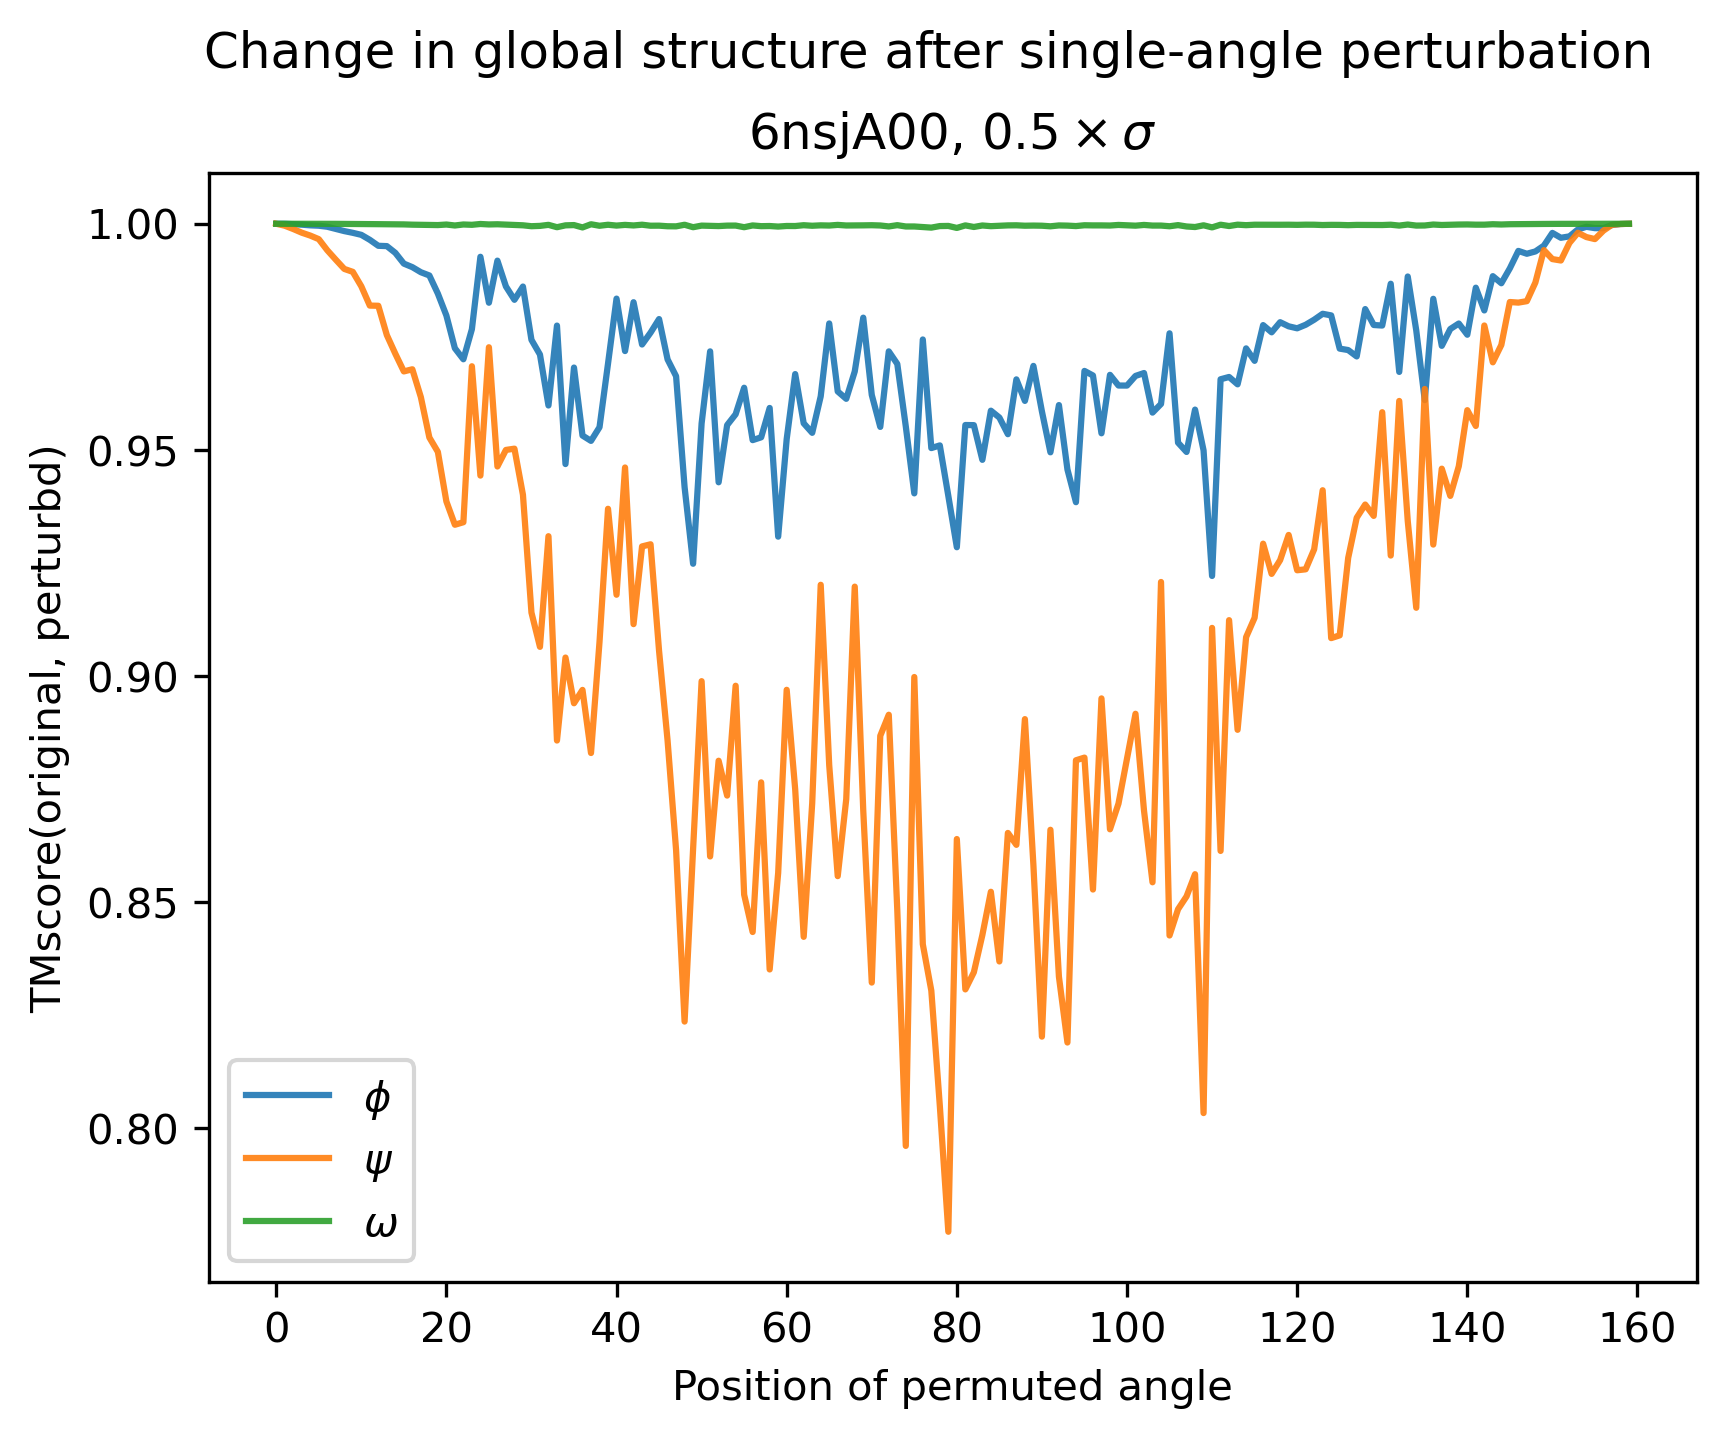

In [26]:
def plot_tm_deltas(tm_deltas: np.ndarray, fname: str = "", **kwargs):
    fig, ax = plt.subplots(dpi=300)
    sns.lineplot(x=np.arange(len(tm_deltas)), y=tm_deltas[:, 0], label=r"$\phi$", alpha=0.9)
    sns.lineplot(x=np.arange(len(tm_deltas)), y=tm_deltas[:, 1], label=r"$\psi$", alpha=0.9)
    sns.lineplot(x=np.arange(len(tm_deltas)), y=tm_deltas[:, 2], label=r"$\omega$", alpha=0.9)
    ax.legend()

    if 'title' in kwargs:
        ax.set(
            xlabel="Position of permuted angle",
            ylabel="TMscore(original, perturbd)",
            **kwargs,
        )
        fig.suptitle("Change in global structure after single-angle perturbation")
    else:
        ax.set(
            xlabel="Position of permuted angle",
            ylabel="TMscore(original, perturbd)",
            title="Change in global structure after single-angle perturbation",
            **kwargs,
        )
    if fname:
        fig.savefig(fname, bbox_inches='tight')
    return fig

plot_tm_deltas(tm_deltas, title=r"6nsjA00, $0.5 \times \sigma$").show()

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

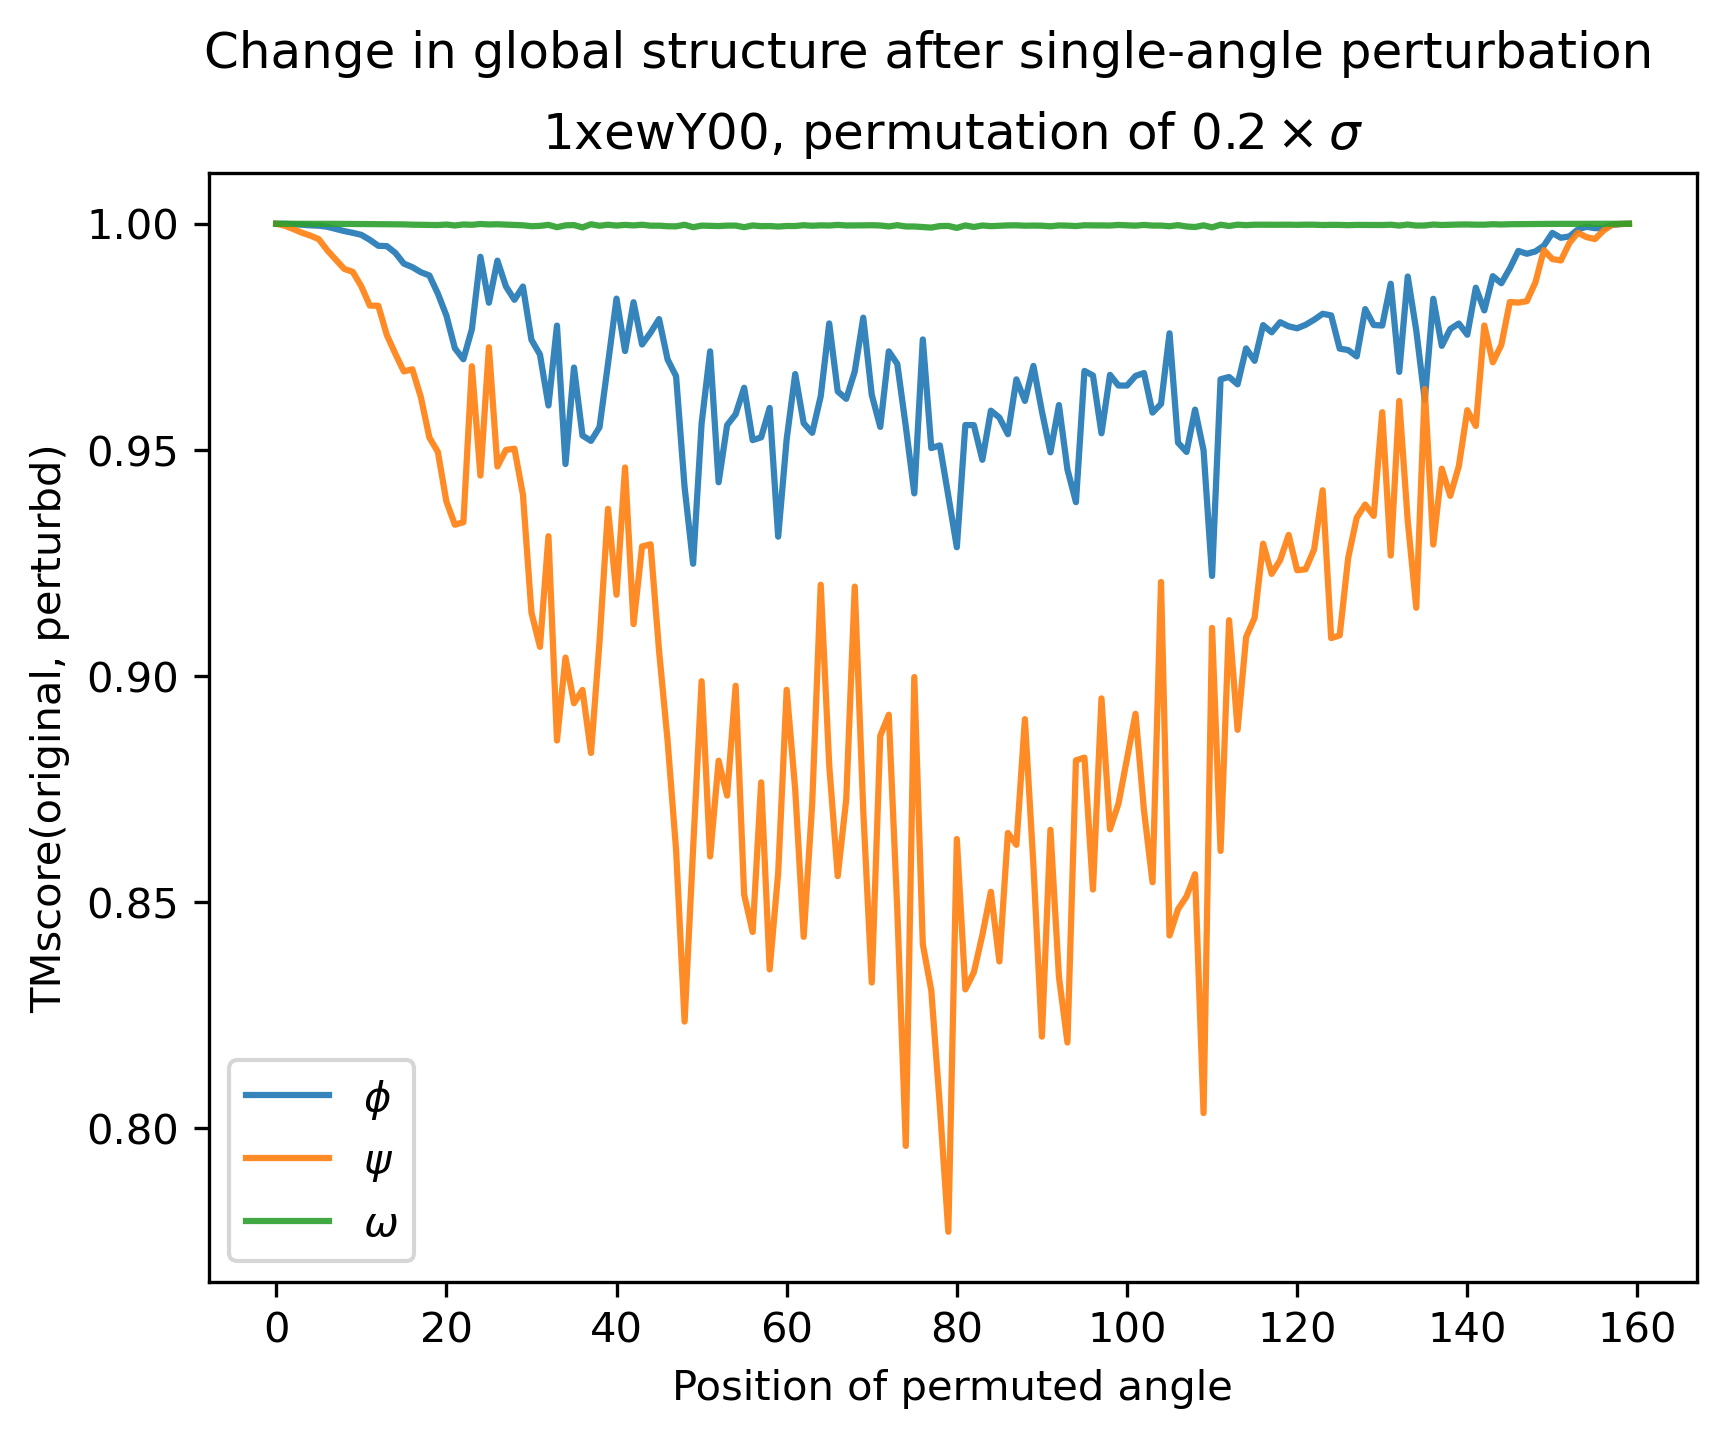

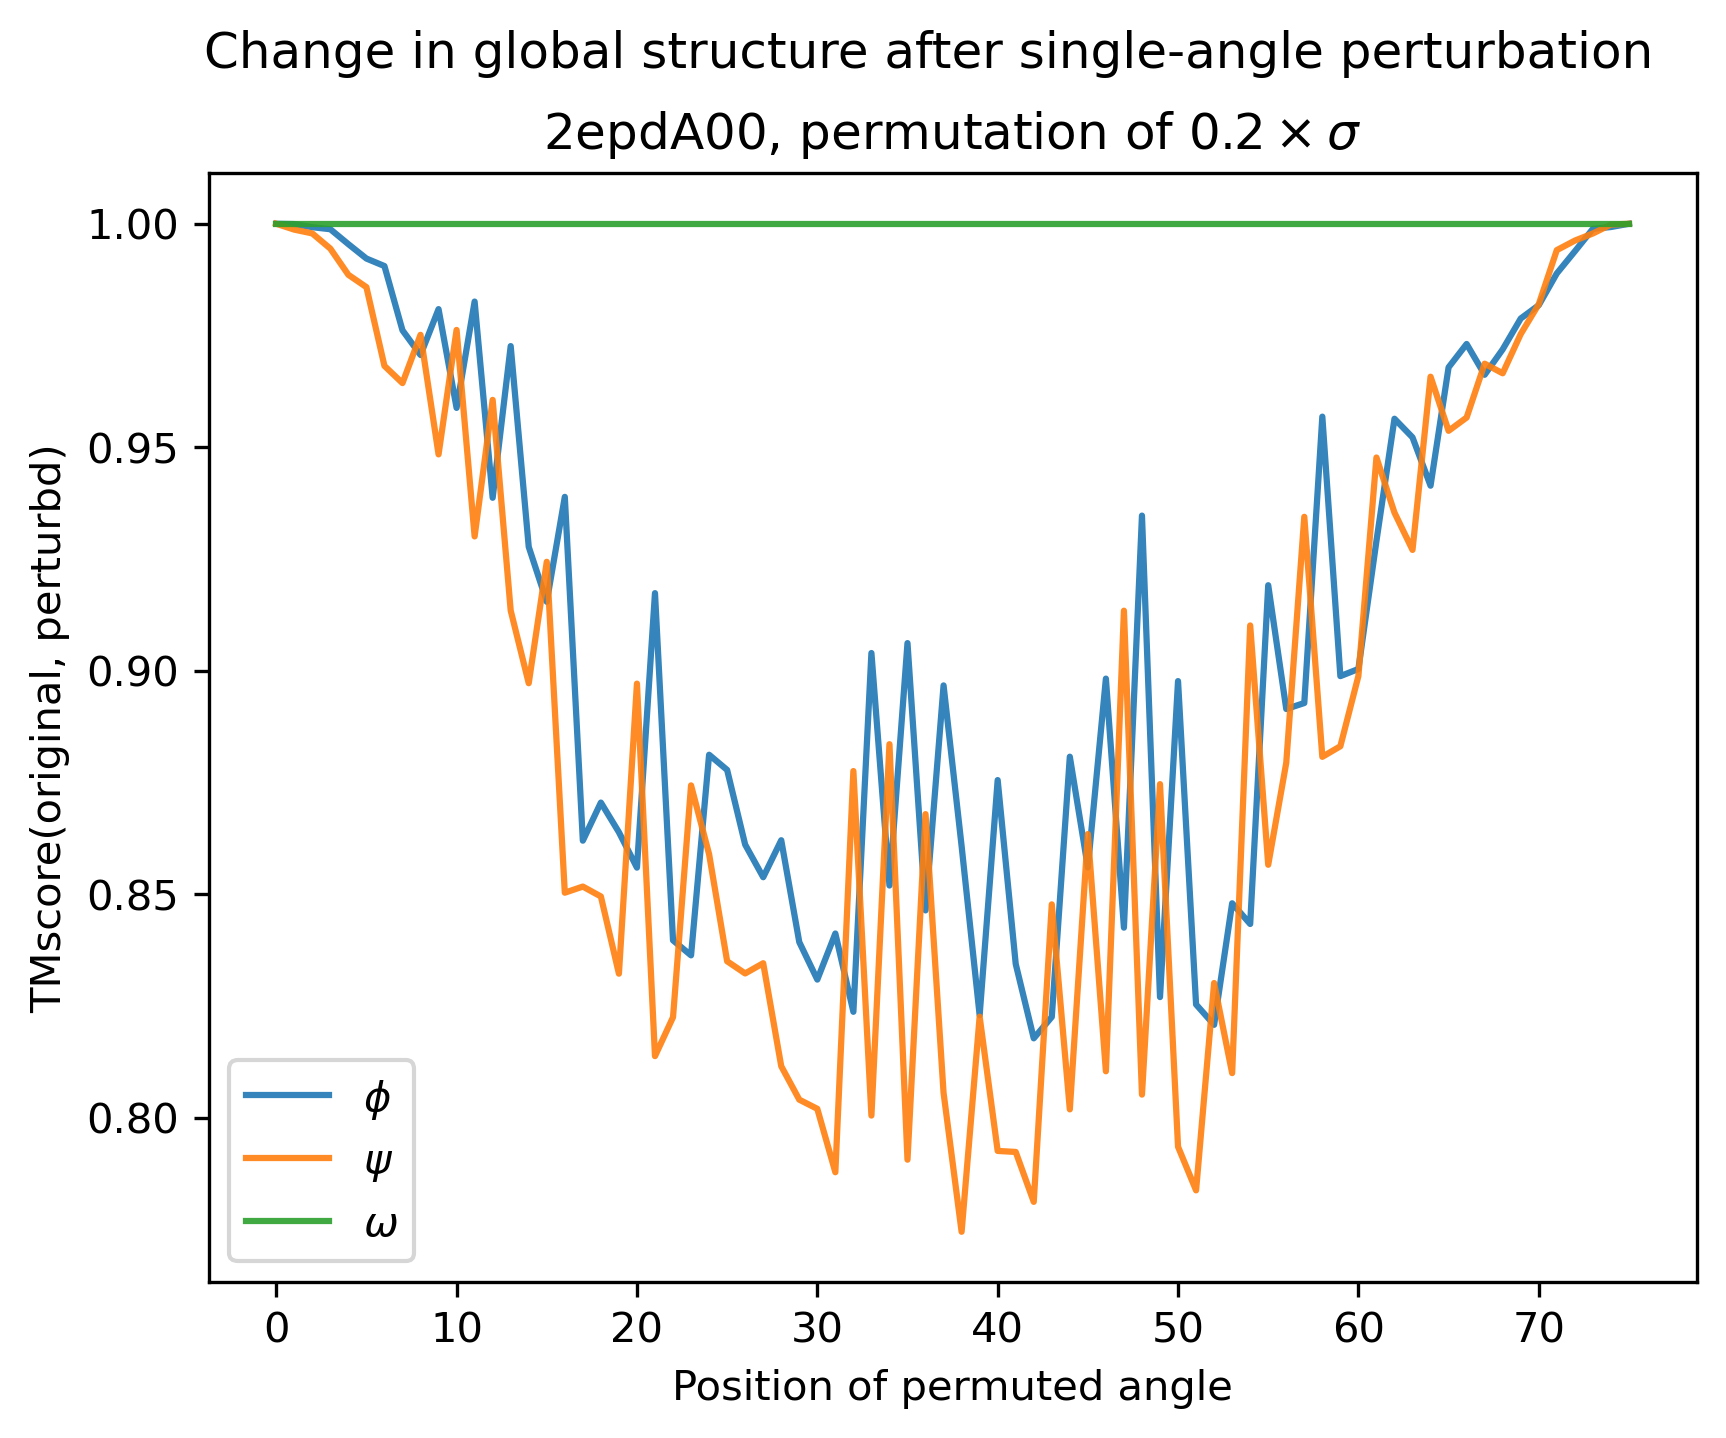

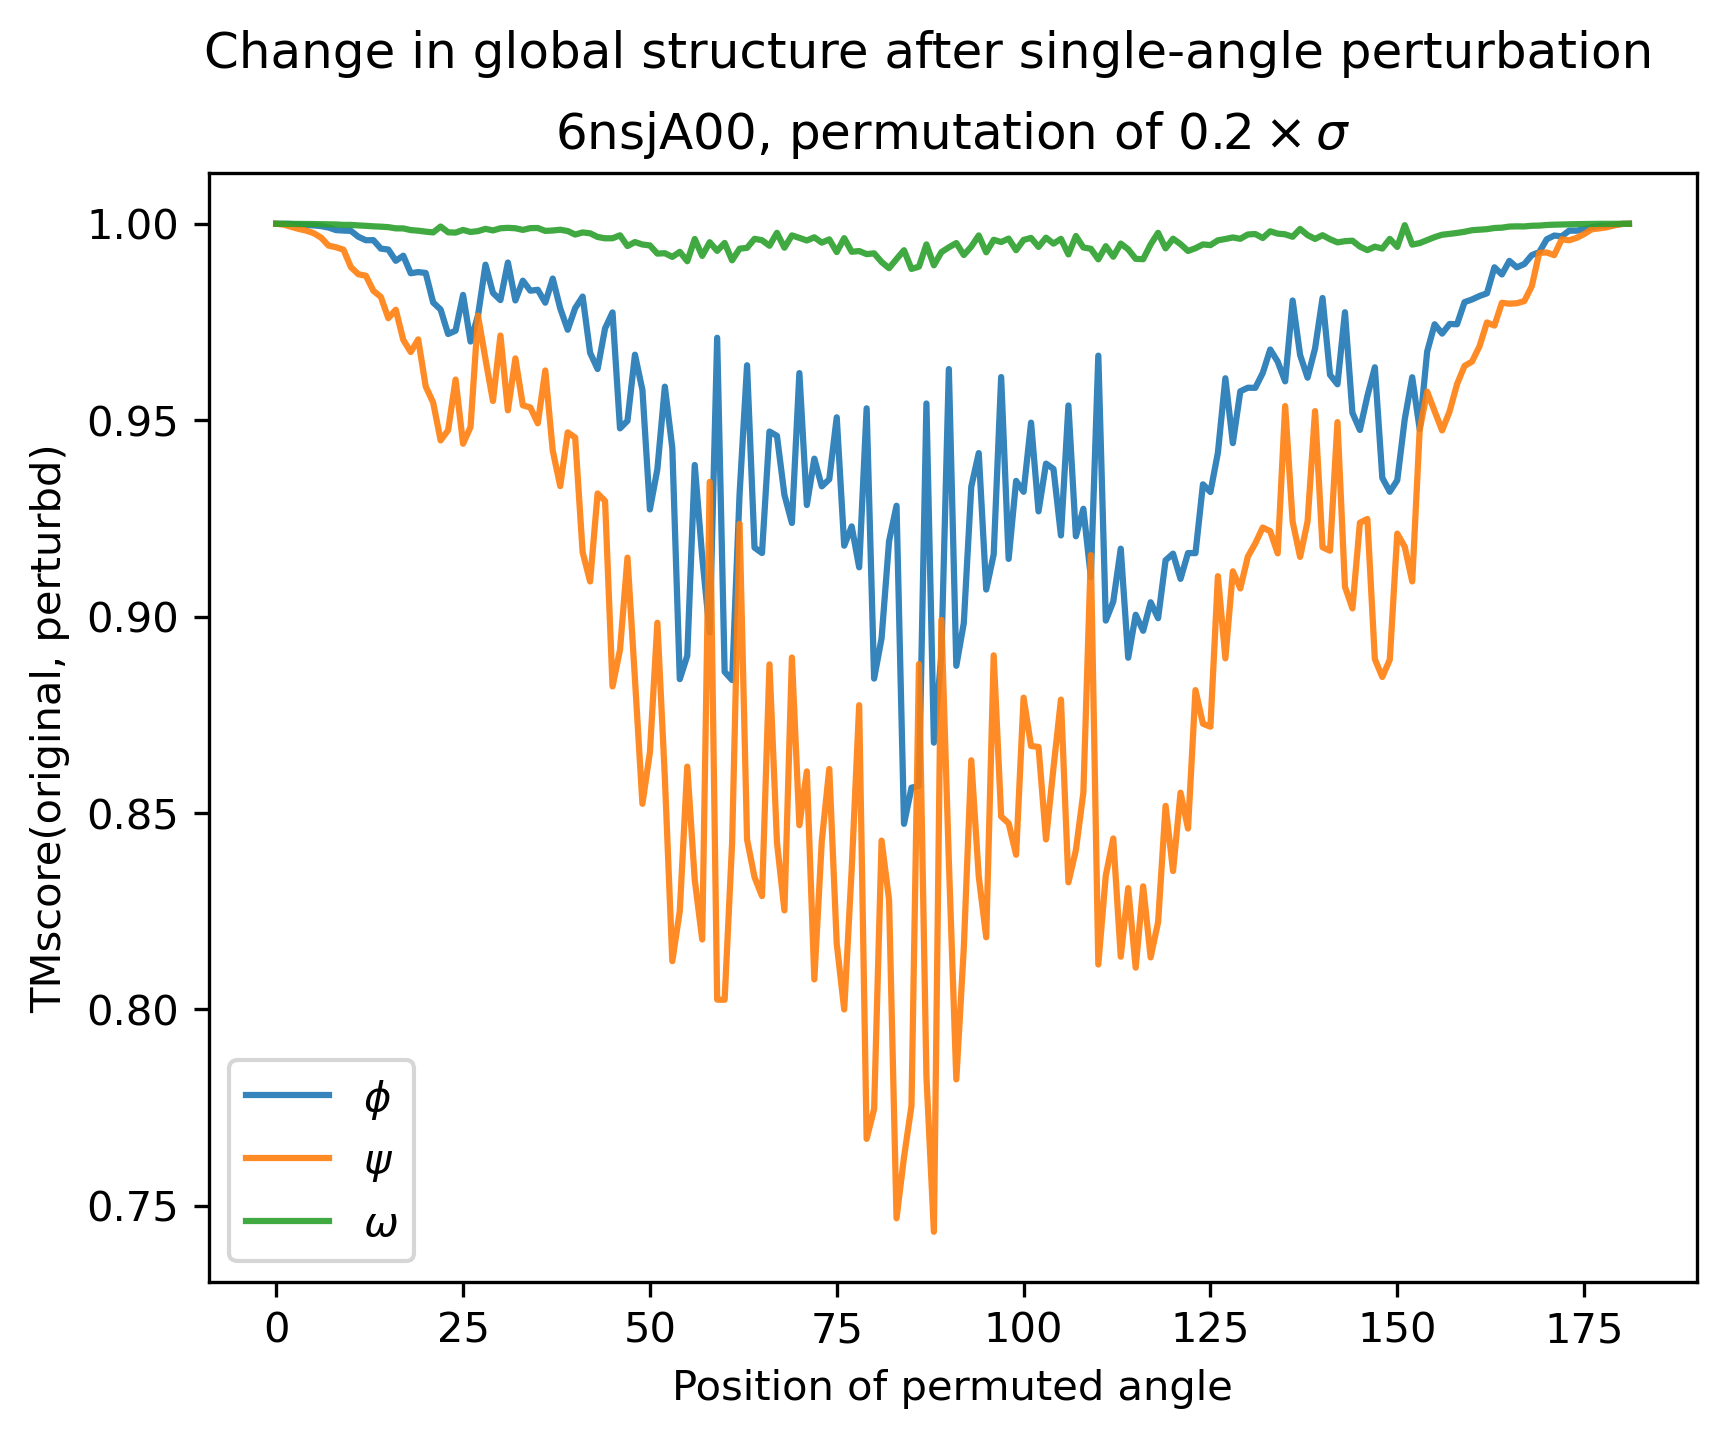

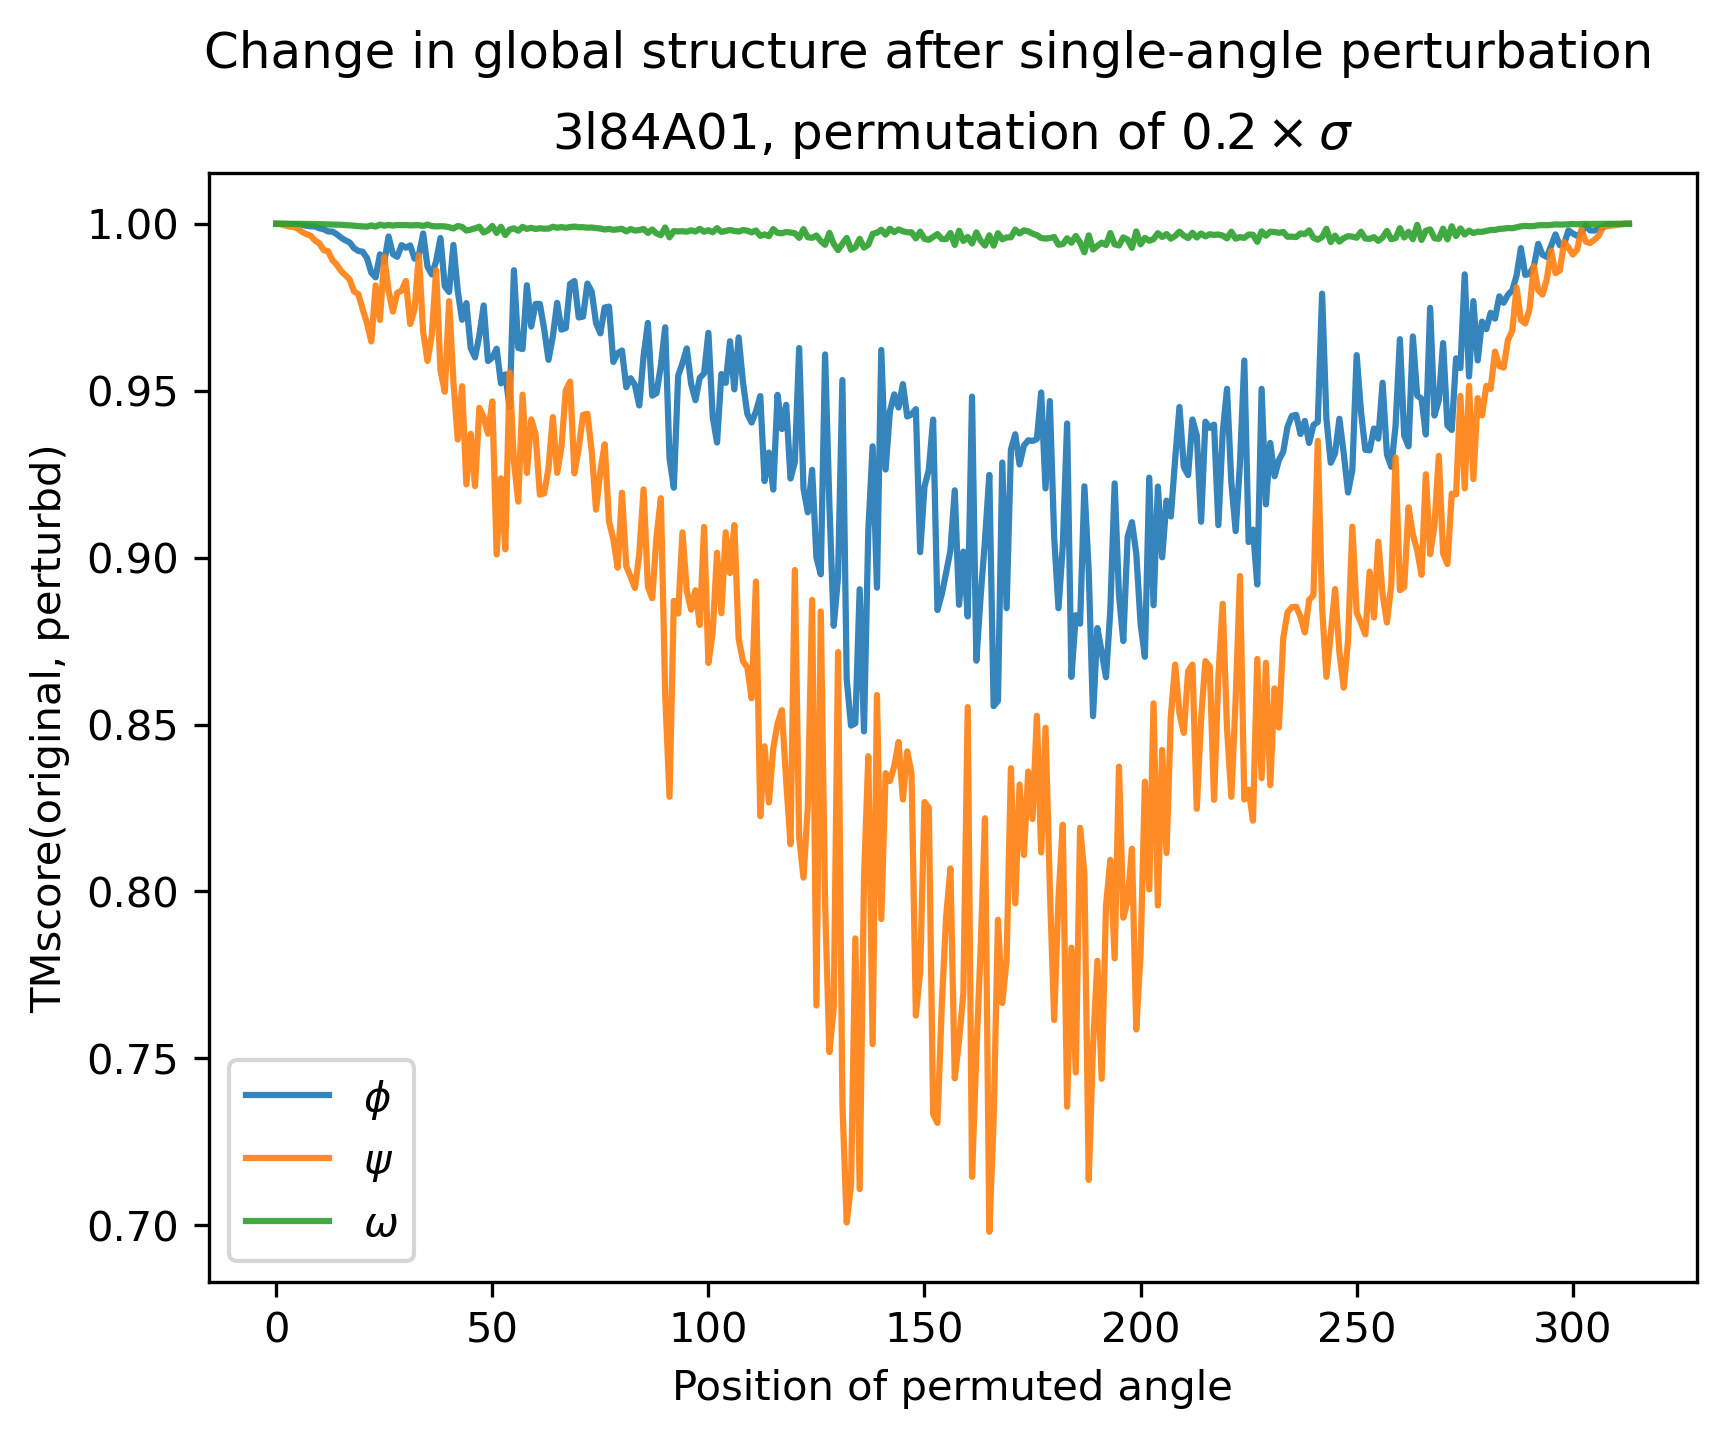

In [27]:
for cath_fname in ["1xewY00", "2epdA00", "6nsjA00", "3l84A01"]:
    tm_deltas = sweep_angles_for_tmscore(
        f"/home/wukevin/projects/protdiff/data/cath/dompdb/{cath_fname}",
        scalar=0.2,
    )
    plot_tm_deltas(
        tm_deltas,
        title=cath_fname + r", permutation of $0.2 \times \sigma$",
        fname=os.path.join(PLOT_DIR, f"0.2_perturbation_{cath_fname}.pdf")
    ).show()

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/182 [00:00<?, ?it/s]

  0%|          | 0/314 [00:00<?, ?it/s]

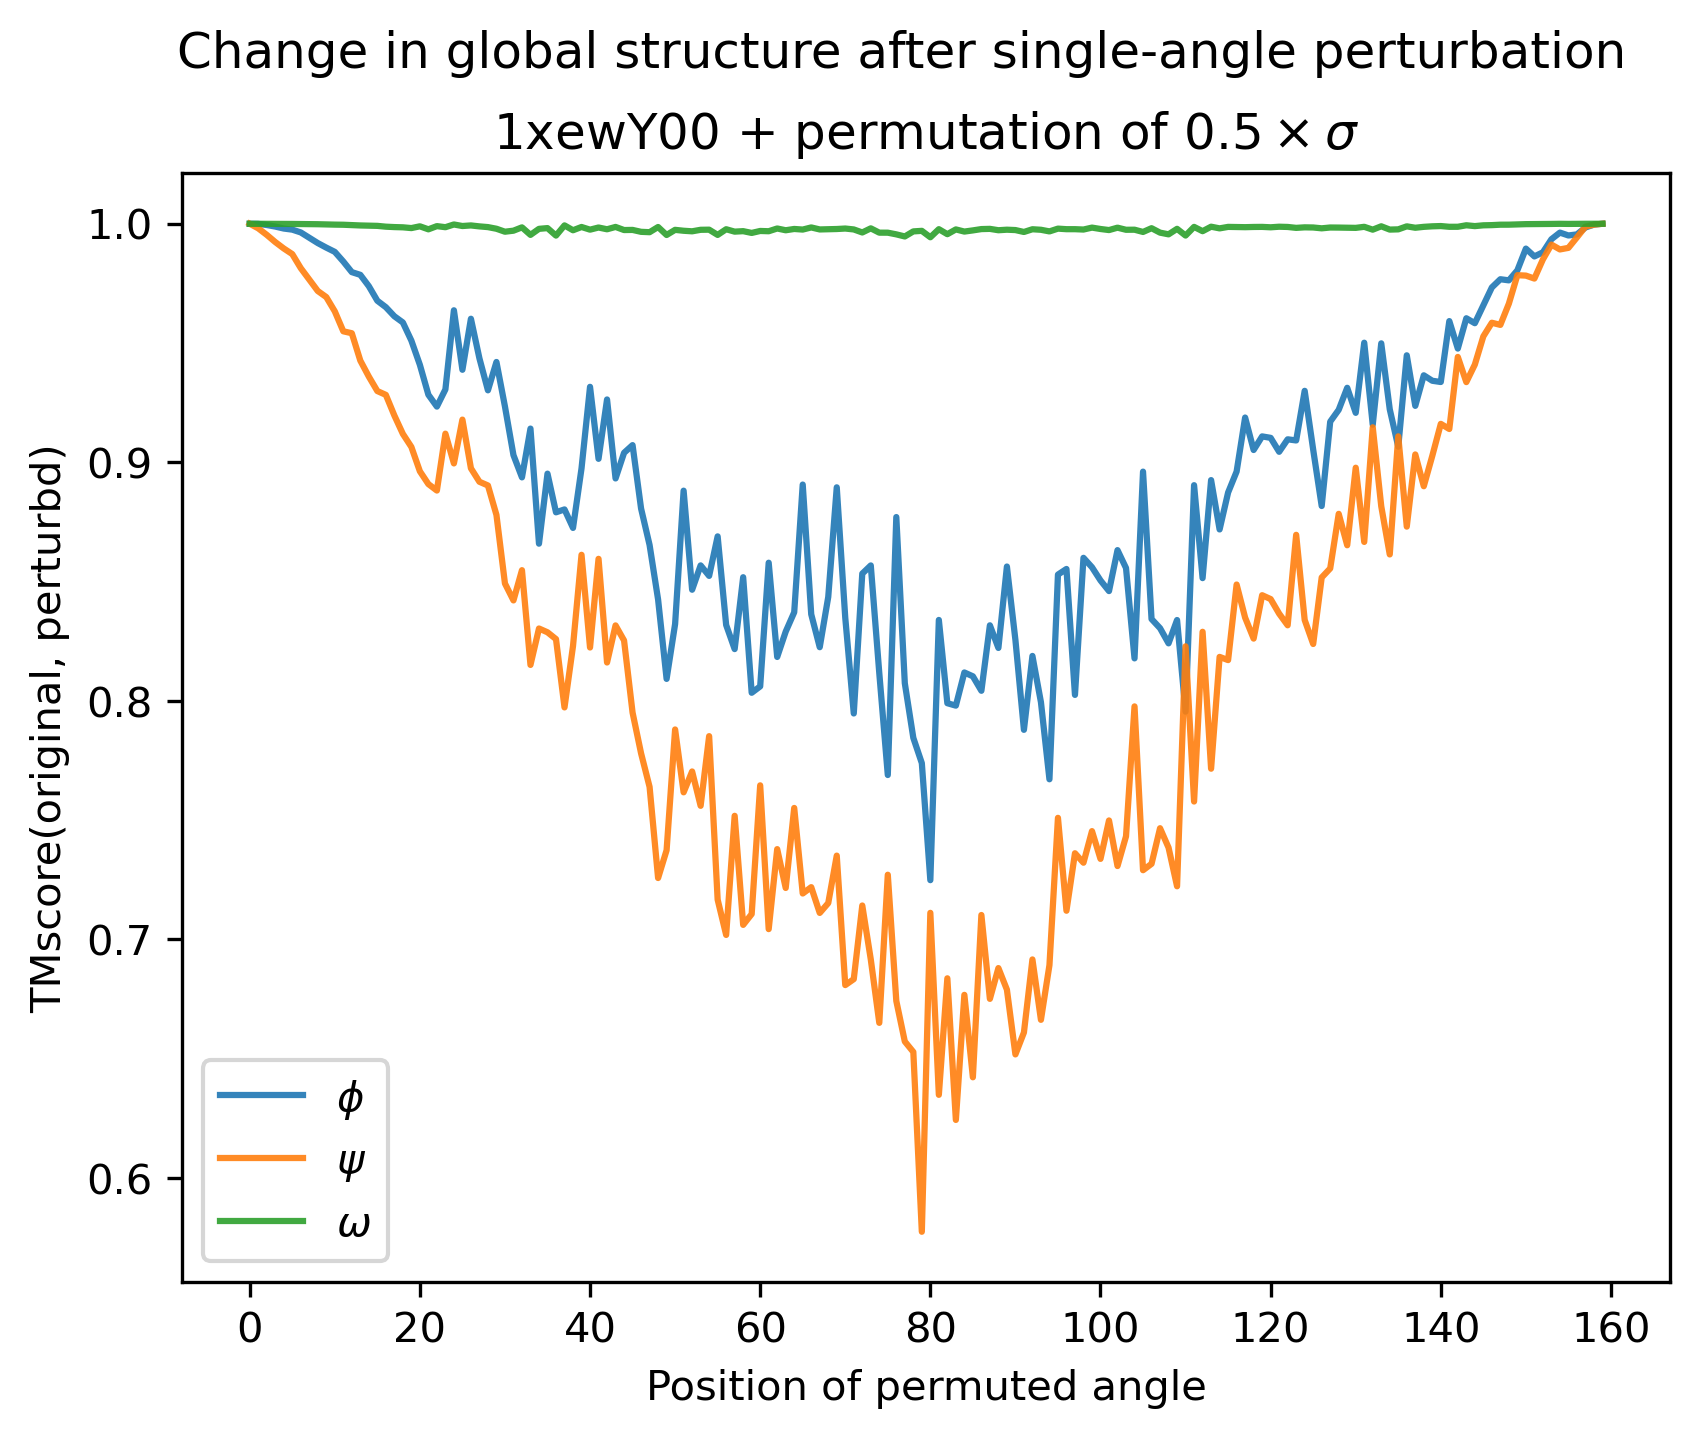

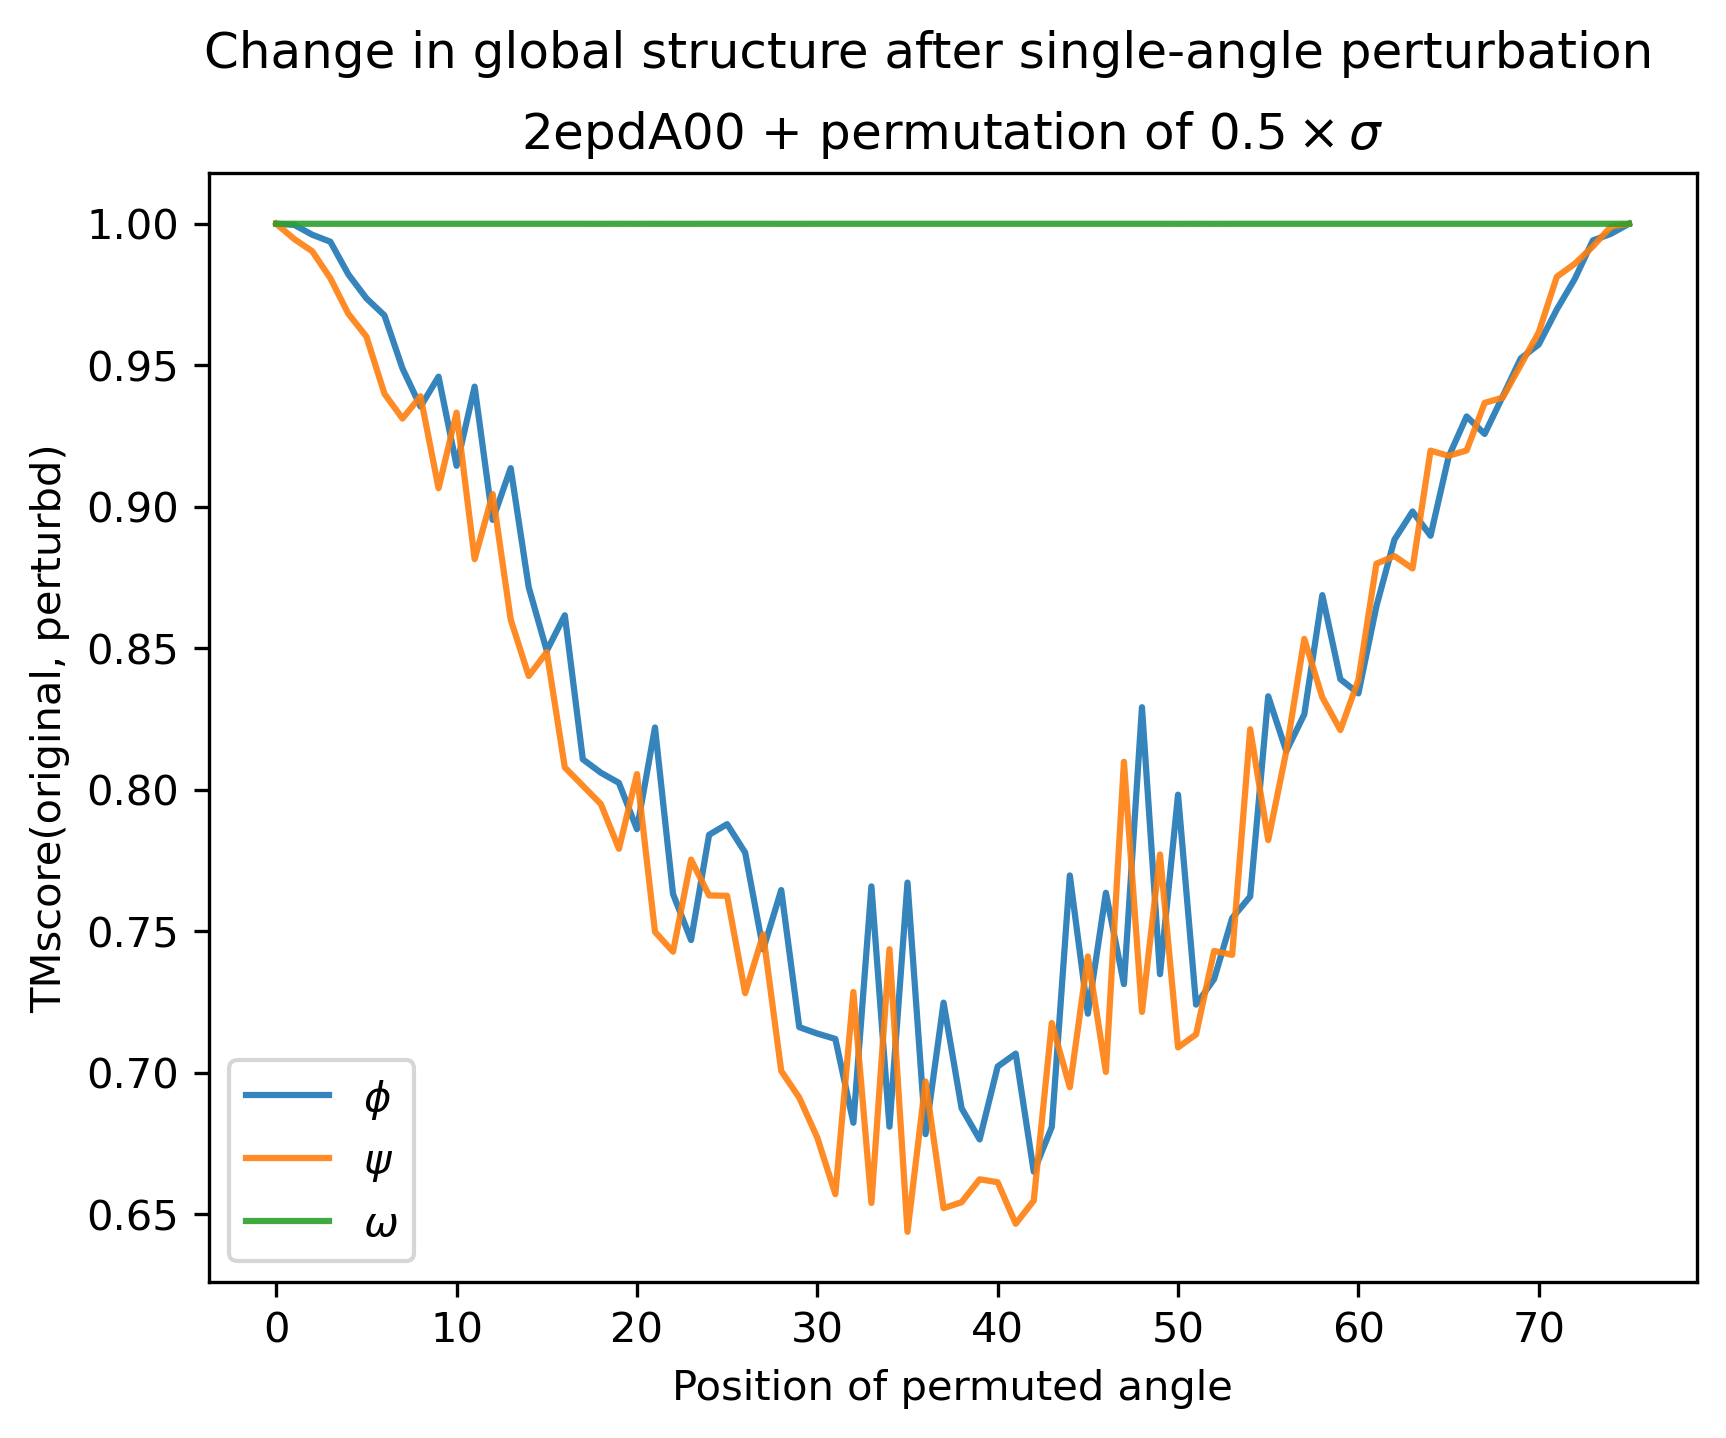

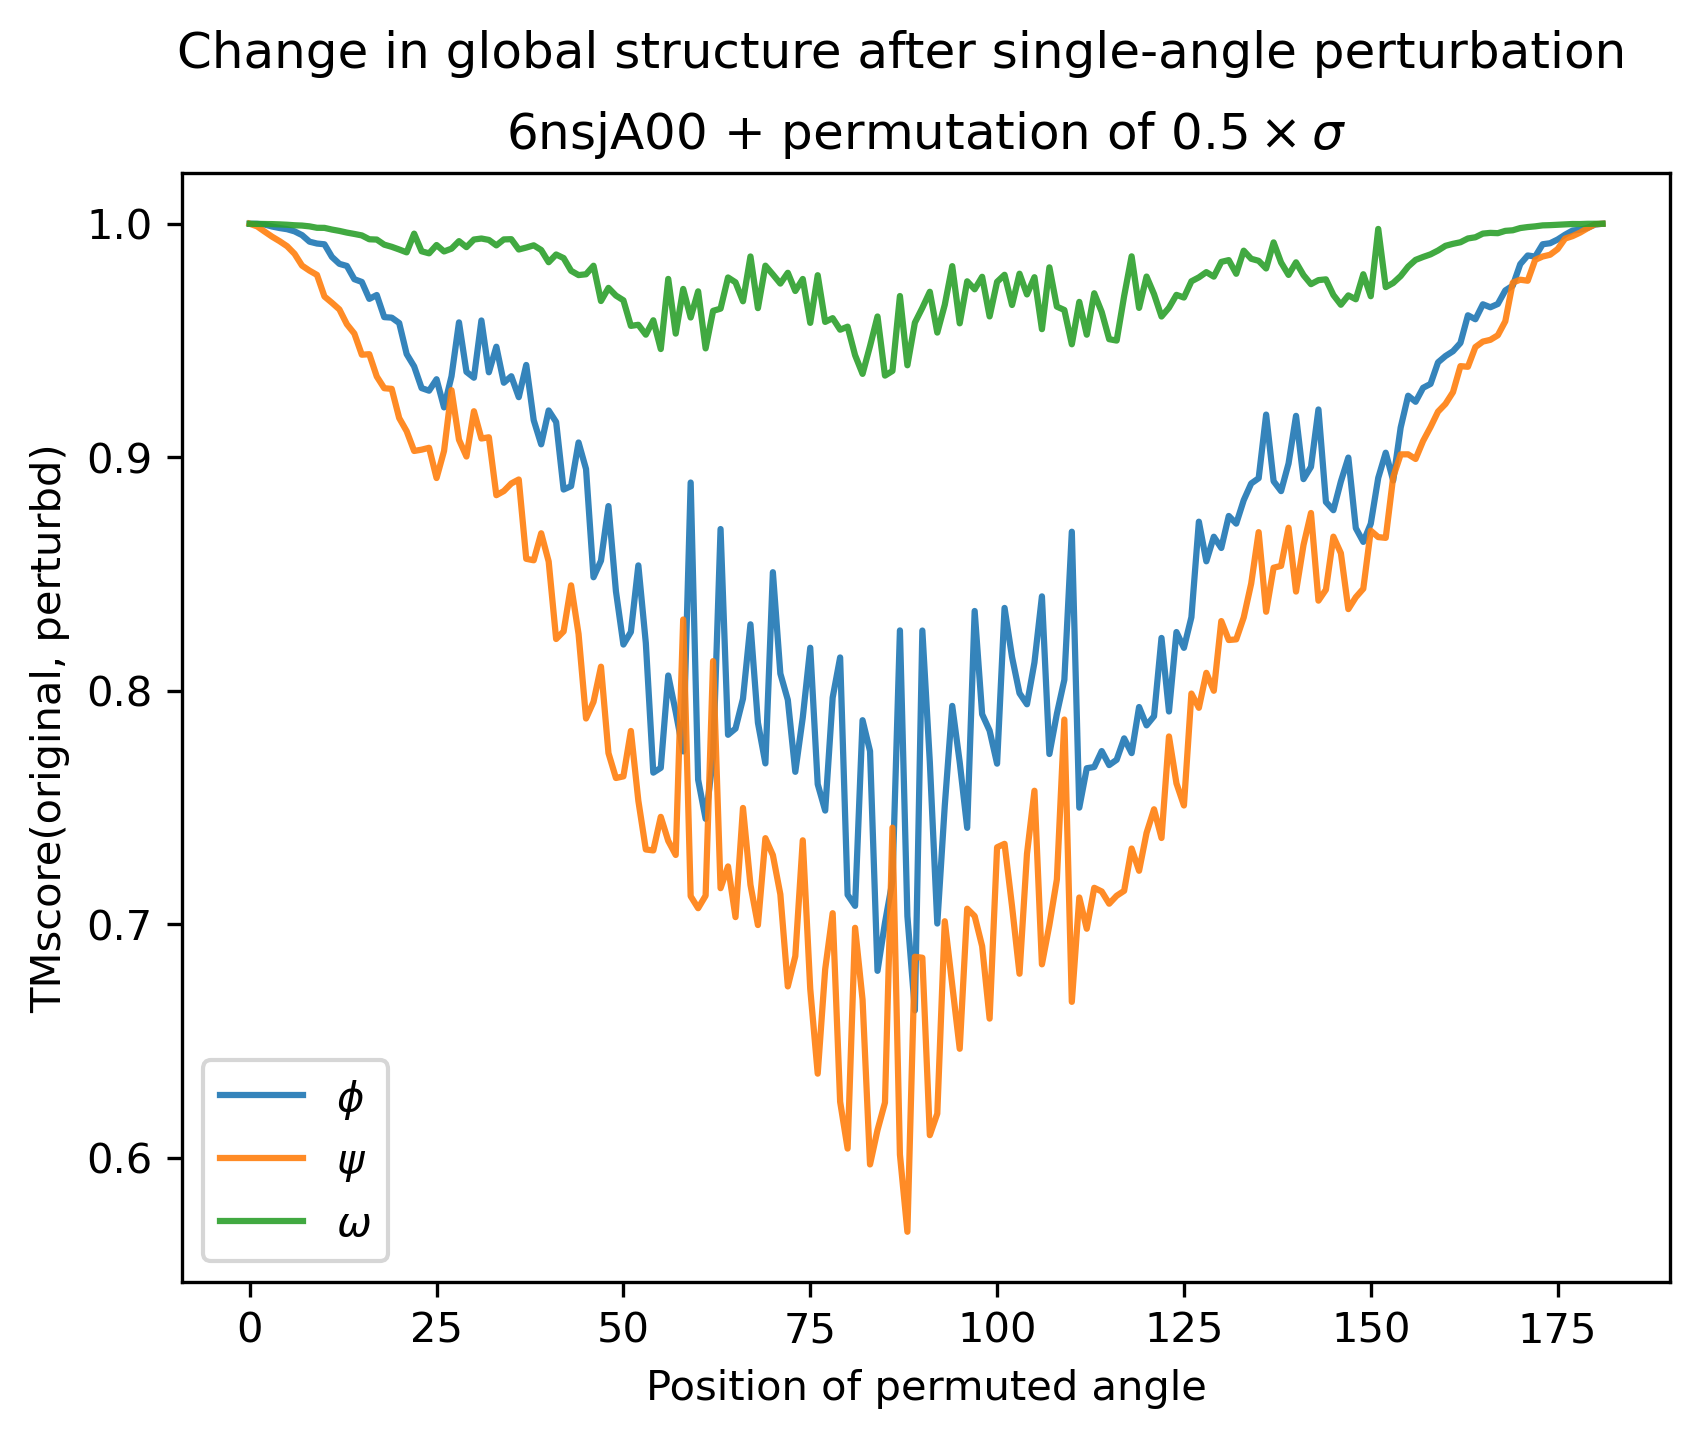

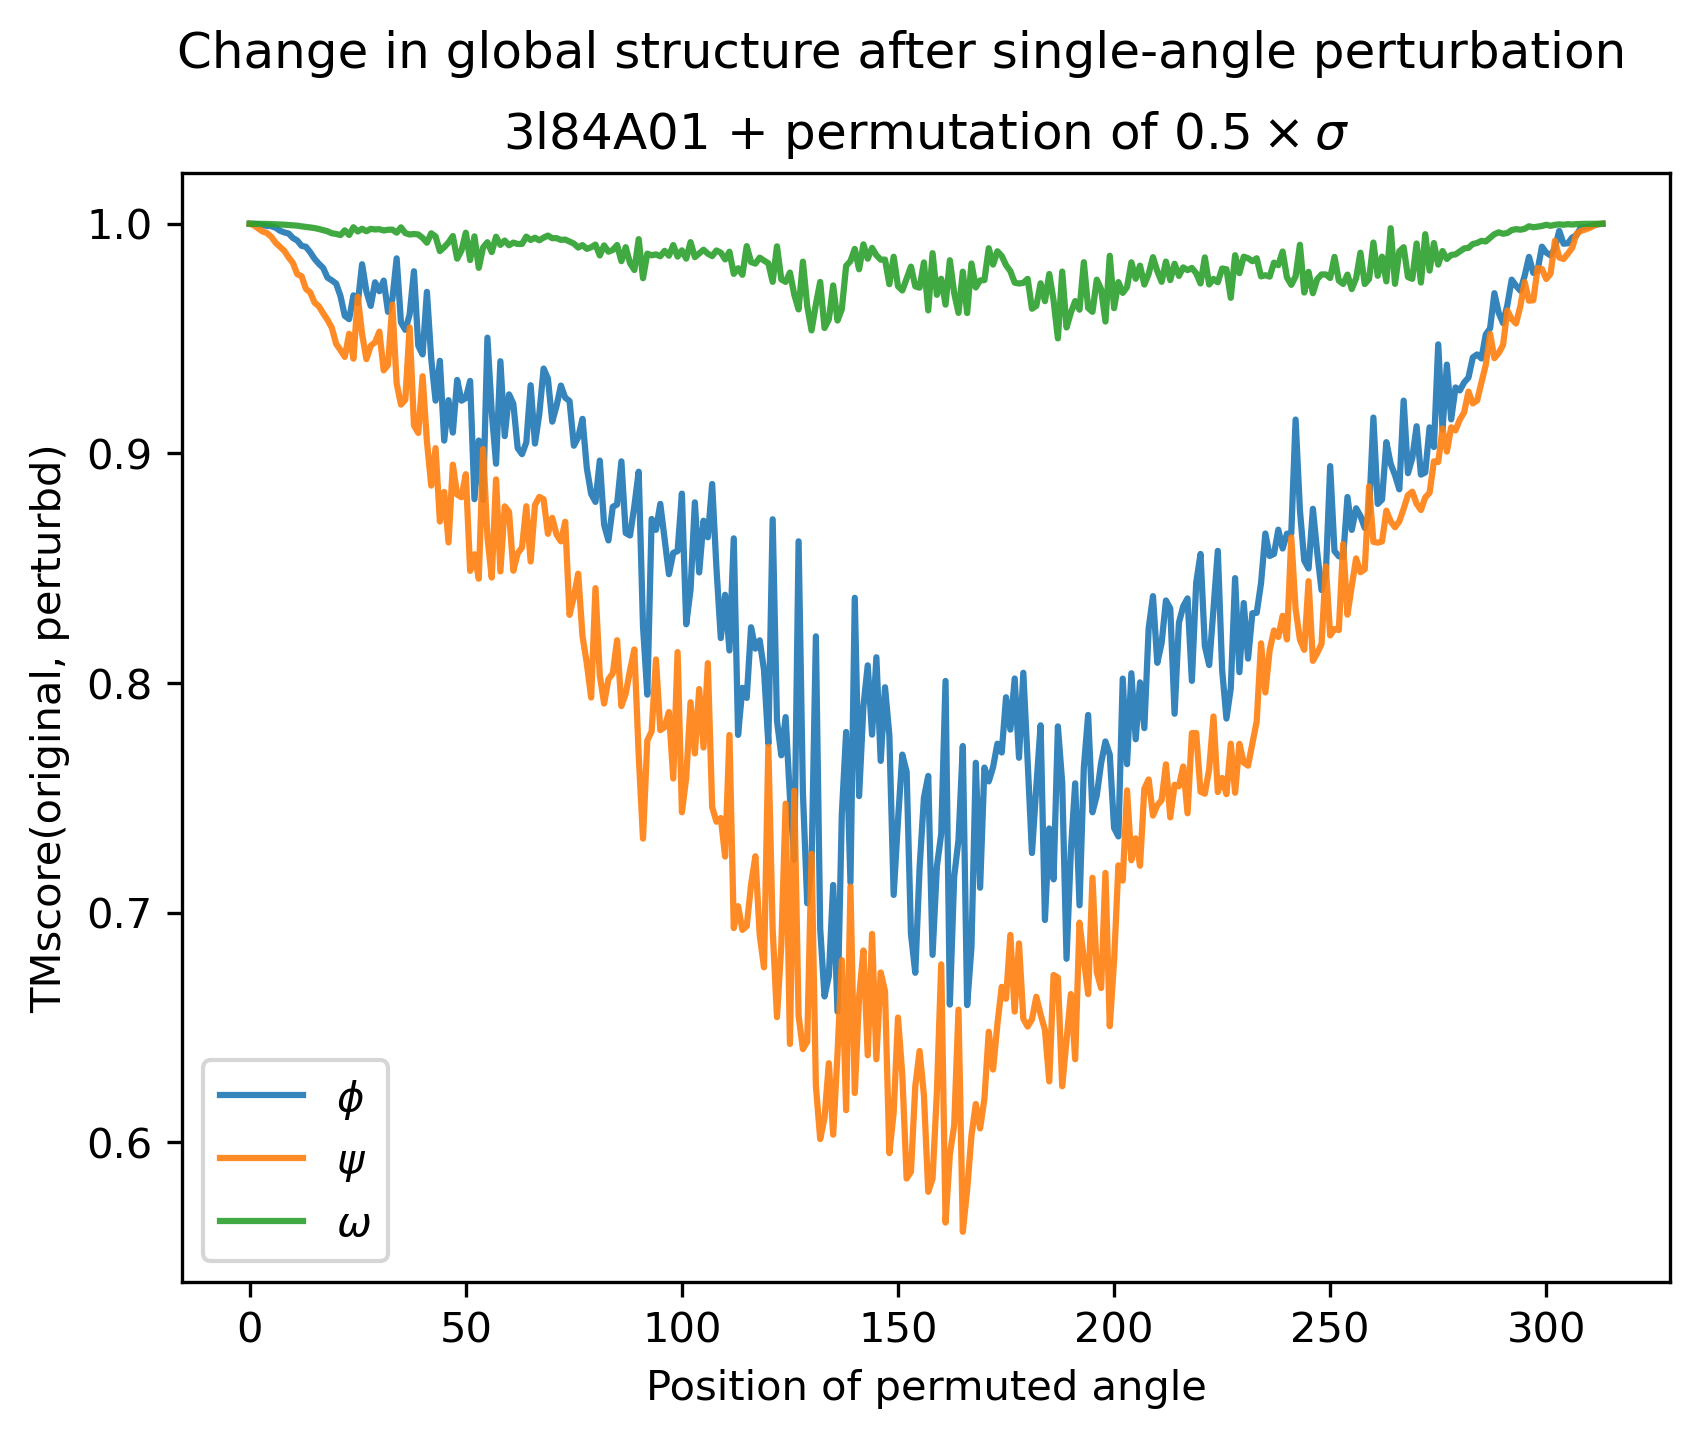

In [30]:
for cath_fname in ["1xewY00", "2epdA00", "6nsjA00", "3l84A01"]:
    tm_deltas = sweep_angles_for_tmscore(
        f"/home/wukevin/projects/protdiff/data/cath/dompdb/{cath_fname}",
        scalar=0.5,
    )
    plot_tm_deltas(
        tm_deltas,
        title=cath_fname + r" + permutation of $0.5 \times \sigma$",
        fname=os.path.join(PLOT_DIR, f"0.5_perturbation_{cath_fname}.pdf")
    ).show()